# Prey Predator simulation

In [1]:
%%capture
%matplotlib inline
from sim import run
from time import time
import matplotlib.pyplot as plt

In [2]:
results = run.run()


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f5ab4faa8d0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f5ab4faa8d0>]


In [3]:
agent_ds = results.dataset[0].agents
site_ds = results.dataset[0].sites

In [4]:
prey_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'prey']))
predator_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'predator']))
food_availability = site_ds.map(lambda s: s.sum())
x = range(len(prey_count))

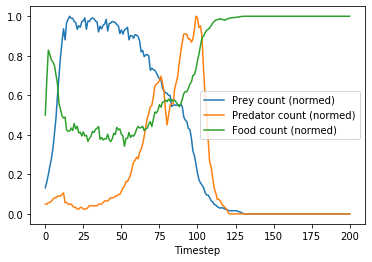

In [5]:
plt.plot(x, prey_count / prey_count.max(), color='C0', label='Prey count (normed)')
plt.plot(x, predator_count / predator_count.max(), color='C1', label='Predator count (normed)')
plt.plot(x, food_availability / food_availability.max(), color='C2', label='Food count (normed)')
plt.xlabel('Timestep')
plt.legend()
plt.show()

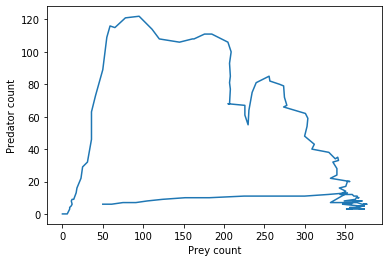

In [6]:
plt.plot(prey_count, predator_count)
plt.xlabel("Prey count")
plt.ylabel("Predator count")
plt.show()

In [7]:
plt.plot(prey_count, food_history)
plt.xlabel("Prey count")
plt.ylabel("Food availability")
plt.show()

NameError: name 'food_history' is not defined

In [ ]:
plt.plot(predator_count, food_history)
plt.xlabel("Predator count")
plt.ylabel("Food availability")
plt.show()